# Training Diffusion Model - No vision

[LQR3D][@carlo change] Obs: x, x_dot, y, y_dot
[@carlo change] Action: x_acc, y_ acc (?)
Observation Dim:  6 Action Dim:  3
batch['obs'].shape: torch.Size([256, 2, 6])
batch['action'].shape torch.Size([256, 16, 3])


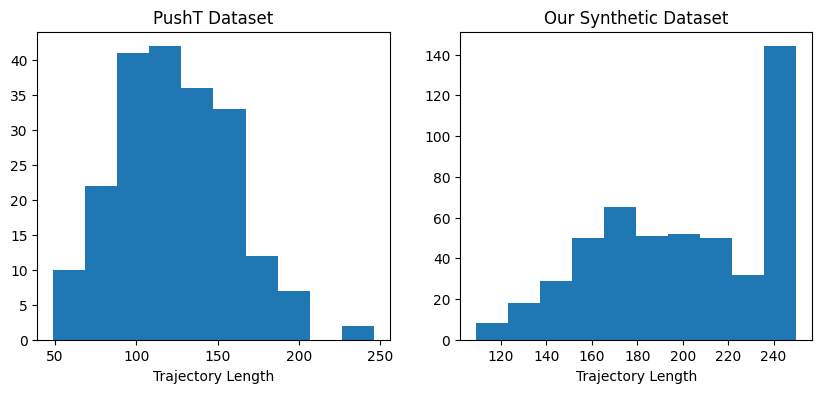

In [1]:
# from imports import * # just some imports
from PushTDataset import *

# Import synthetic dataset
dataset_pushT = load_dataset_push_t() # same dataset as the paper

# for 2d dataset 8 is ok for 3d 4

# dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed = load_dataset_lqr2d() # to clean,  @carlo
# SHRINK = 8 # how much small the network wrt papers

dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed  = load_dataset_lqr3d() # to clean, @carlo
SHRINK = 2

# dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed  = load_dataset_drone() # to clean,  @carlo
# dataset_ours, obs_dim, action_dim, name, fn_distance, fn_speed  = load_dataset_lqr2d_observation() # to clean,  @carlo

# Show distribution of trajectories length
show_statistics(dataset_paper=dataset_pushT,
                dataset_ours=dataset_ours)

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset_ours,
    batch_size=256,
    num_workers=4,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process after each epoch
    persistent_workers=True
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

In [ ]:
# dataset_pushT.stats['action'], dataset_pushT.stats['obs']
dataset_ours.stats['action'], dataset_ours.stats['obs']
# dataset_ours[0], dataset_pushT[0]

# Setup Learning Framework

In [2]:
#@markdown ### **Network Demo**
# from draw import DrawOptions
from Components import *


TYPE = torch.float32
down_dims = [256//SHRINK, 512//SHRINK, 1024//SHRINK]
print('Dimension of the hidden layers: ', down_dims)

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    down_dims = down_dims,
)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim),dtype=TYPE)
obs = torch.zeros((1, obs_horizon, obs_dim), dtype=TYPE)
diffusion_iter = torch.zeros((1,), dtype=TYPE)

# the noise prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
noise = noise_pred_net(
    sample=noised_action,
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1))

# illustration of removing noise
# the actual noise removal is performed by NoiseScheduler
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    model=noise_pred_net,
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)

Dimension of the hidden layers:  [128, 256, 512]
number of parameters: 1.771751e+07


# Training Loop

In [ ]:
now = datetime.now()  # current date and time
date_time = now.strftime("%m_%d_%H_%M_%S")

folder = f'pretrained/{name}_shr{SHRINK}_{date_time}'
if not os.path.isfile(folder):
    os.mkdir(folder)

writer = SummaryWriter(log_dir=folder) # log tensorboard

LOSS = []
with tqdm(range(num_epochs), desc='Epoch', leave=False) as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        if epoch_idx%20 == 0:
            torch.save(ema.averaged_model.state_dict(), f'./{folder}/model_{name}_ema_{epoch_idx}_{num_epochs}_shr{SHRINK}.ckpt')

        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                B = nobs.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                obs_cond = obs_cond.flatten(start_dim=1).float()

                # sample noise to add to actions
                noise = torch.randn(naction.shape, device=device) # can be done a priori before starting

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,), device=device
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps).float()

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net)

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        writer.add_scalar('Training/loss_avg', np.mean(epoch_loss), epoch_idx)
        writer.add_scalar('Training/loss_std', np.std(epoch_loss), epoch_idx)

        LOSS.append(epoch_loss)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

torch.save(noise_pred_net.state_dict(), f'./{folder}/model_{name}_{epoch_idx}_{num_epochs}_shr{SHRINK}.ckpt')
torch.save(ema.averaged_model.state_dict(), f'./{folder}/model_{name}_ema_{epoch_idx}_{num_epochs}_shr{SHRINK}.ckpt')

# Weights of the EMA model
# is used for inference
ema_noise_pred_net = ema.averaged_model        # 0.000204,    # 0.000517

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/380 [00:00<?, ?it/s]

Batch:   0%|          | 0/380 [00:00<?, ?it/s]

Batch:   0%|          | 0/380 [00:00<?, ?it/s]

Batch:   0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(1,1)
for l in LOSS[:]:
    ax.plot(l)
plt.show()

with open(f'{folder}/LOSS_model_{name}_ema_{epoch_idx}_{num_epochs}_shr{SHRINK}.pickle', 'wb') as handle:
    pickle.dump(LOSS, handle, protocol=pickle.HIGHEST_PROTOCOL)